Fitting 4 folds for each of 16 candidates, totalling 64 fits

✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 22, 'min_samples_leaf': 1}

📈 4-Fold Cross-Validation F1 Scores on Train Set: [0.56451688 0.55422728 0.54655821 0.57582658]
📌 Mean CV Score: 0.5603

📊 Validation Set Classification Report:
              precision    recall  f1-score   support

         AFM       0.24      0.40      0.30       547
          FM       0.80      0.73      0.76      5766
         FiM       0.31      0.38      0.34       822
          NM       0.87      0.86      0.87      4107

    accuracy                           0.74     11242
   macro avg       0.56      0.59      0.57     11242
weighted avg       0.76      0.74      0.75     11242



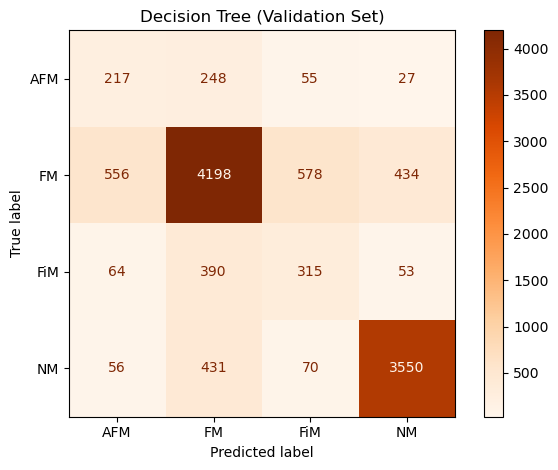

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === 1. Load CSV ===
df = pd.read_csv("Materials_With_AtLeast_OneMagneticElement.csv")


# === 3. Parse elements ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 4. Extract crystal system ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 5. Drop missing values ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 6. One-hot encode elements and crystal system ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([df[numerical_features].reset_index(drop=True),
               element_df.reset_index(drop=True),
               crystal_df.reset_index(drop=True)], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. 60/20/20 Split ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 10. Cross-validation & Grid Search ===
param_grid = {
    'max_depth': [22, 30, 36, 40],
    'min_samples_leaf': [1, 3, 5, 10],
    'class_weight': ['balanced']
}

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt, param_grid, cv=skf, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# === 11. Best Model from CV ===
best_clf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}")

# === 12. Cross-Validation Results ===
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring='f1_macro')
print(f"\n📈 4-Fold Cross-Validation F1 Scores on Train Set: {cv_scores}")
print(f"📌 Mean CV Score: {np.mean(cv_scores):.4f}")

# === 13. Fit Best Model and Evaluate on Validation Set ===
best_clf.fit(X_train, y_train)
y_pred_val = best_clf.predict(X_val)

print("\n📊 Validation Set Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=le.classes_, cmap="Oranges", values_format="d")
plt.title("Decision Tree (Validation Set)")
plt.tight_layout()
plt.show()


,params,mean_test_score,rank_test_score
0,"{'class_weight': 'balanced', 'max_depth': 22, ...",0.560282,1
4,"{'class_weight': 'balanced', 'max_depth': 30, ...",0.558329,2
8,"{'class_weight': 'balanced', 'max_depth': 36, ...",0.555869,3
12,"{'class_weight': 'balanced', 'max_depth': 40, ...",0.552726,4
5,"{'class_weight': 'balanced', 'max_depth': 30, ...",0.542578,5
1,"{'class_weight': 'balanced', 'max_depth': 22, ...",0.542108,6
13,"{'class_weight': 'balanced', 'max_depth': 40, ...",0.541766,7
9,"{'class_weight': 'balanced', 'max_depth': 36, ...",0.541555,8
6,"{'class_weight': 'balanced', 'max_depth': 30, ...",0.528782,9
10,"{'class_weight': 'balanced', 'max_depth': 36, ...",0.528124,10


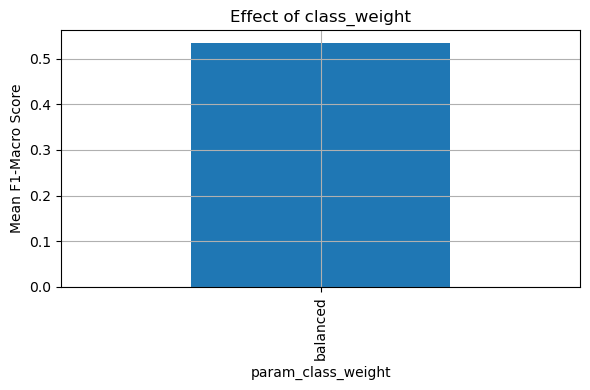

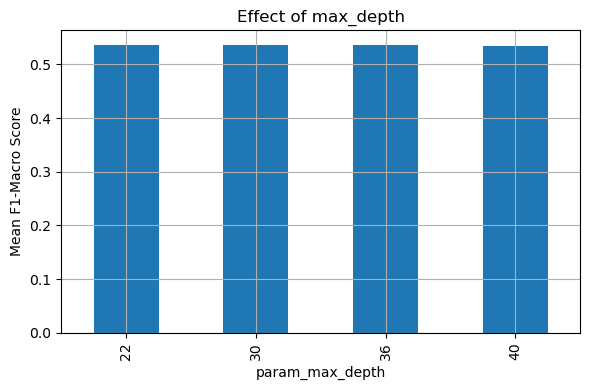

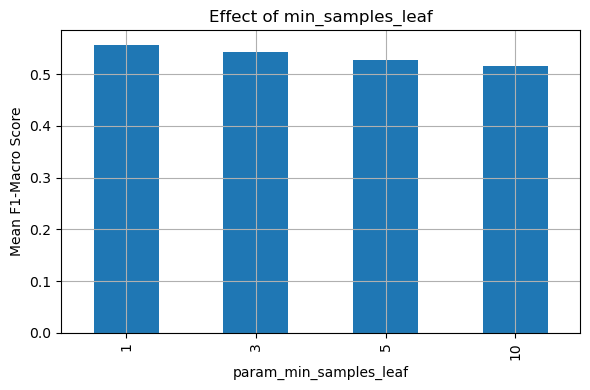

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume `grid_search` is already available in session (from DecisionTree GridSearch)
# Convert cv_results_ to a DataFrame
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Sort by best score
top_results = cv_results_df.sort_values(by='mean_test_score', ascending=False)
top_params = top_results[['params', 'mean_test_score', 'rank_test_score']].head(10)

# Prepare parameter impact plots
param_cols = [col for col in cv_results_df.columns if col.startswith("param_")]
figs = []
for param in param_cols:
    param_score_df = cv_results_df[[param, 'mean_test_score']].copy()
    param_score_df = param_score_df.groupby(param).mean().sort_index()

    fig, ax = plt.subplots(figsize=(6, 4))
    param_score_df.plot(kind='bar', ax=ax, legend=False)
    ax.set_ylabel("Mean F1-Macro Score")
    ax.set_title(f"Effect of {param.replace('param_', '')}")
    ax.grid(True)
    plt.tight_layout()
    figs.append(fig)

top_params


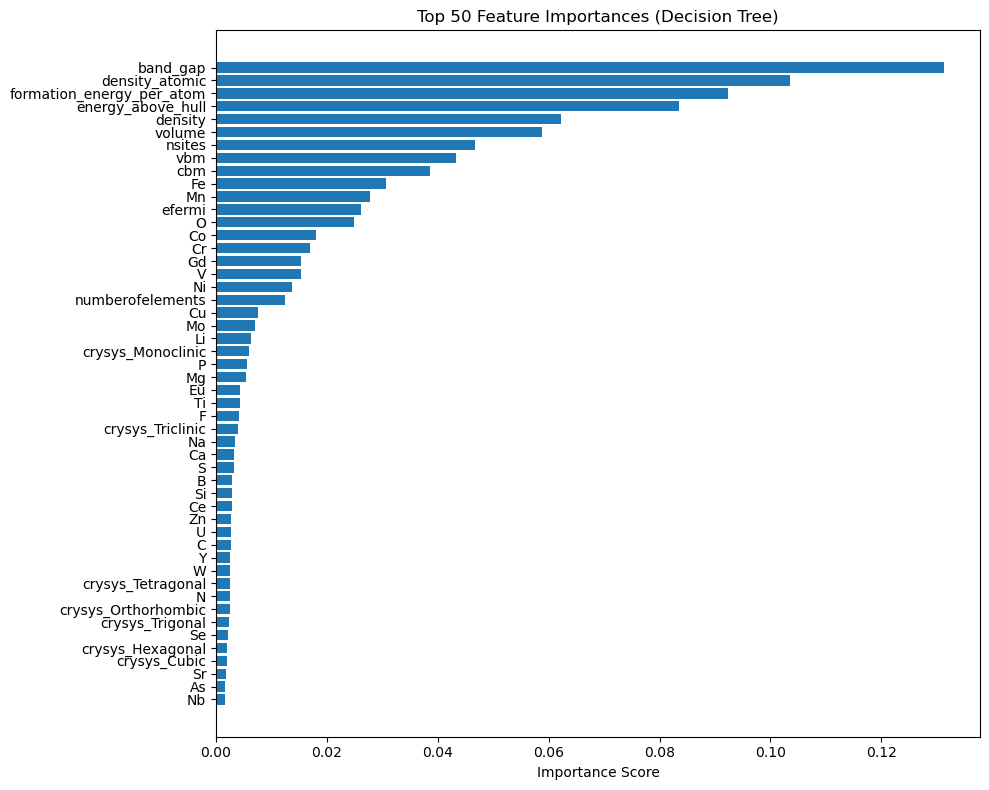

In [3]:
# === 1. Extract feature importances from the trained Decision Tree model ===
importances = best_clf.feature_importances_
 # or grid_search.best_estimator_.feature_importances_

# === 2. Create a DataFrame mapping feature names to their importance ===
feature_names = X.columns  # Ensure this matches your final X
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# === 3. Plot Top 50 Features ===
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df["Feature"].head(50)[::-1], feat_imp_df["Importance"].head(50)[::-1])
plt.xlabel("Importance Score")
plt.title("Top 50 Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()


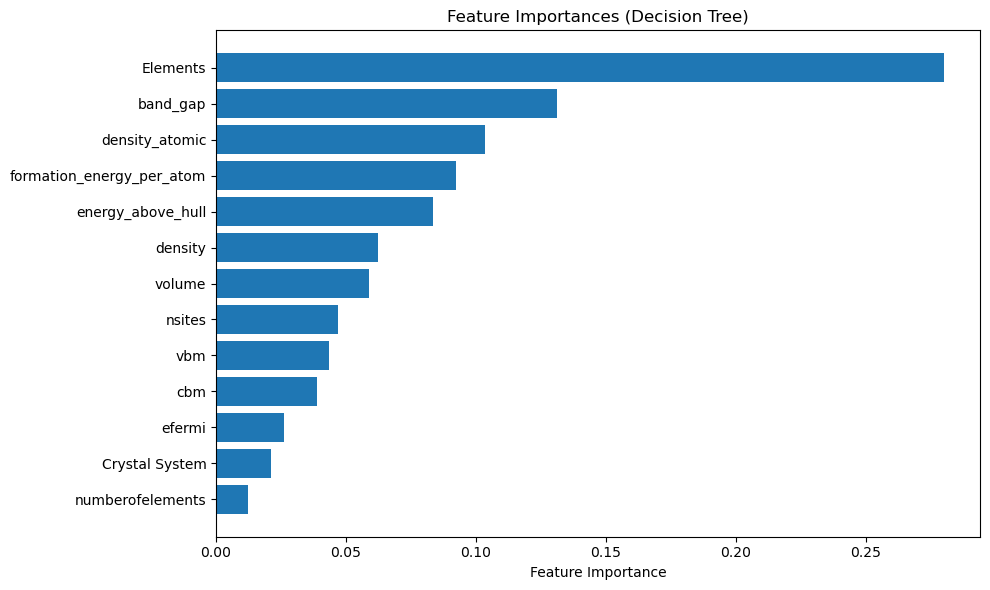

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Reuse ===
feature_names = X.columns

# === Define your groups ===
numerical_features_set = set(numerical_features)
grouped_data = []

elements_importance = 0.0
crysys_importance = 0.0

# === Categorize features ===
for feature, imp in zip(feature_names, importances):
    if feature in numerical_features_set:
        grouped_data.append((feature, imp))  # keep numerical features separate
    elif feature.startswith("crysys_"):
        crysys_importance += imp
    else:
        elements_importance += imp

# Add grouped features
grouped_data.append(("Elements", elements_importance))
grouped_data.append(("Crystal System", crysys_importance))

# === Sort and plot ===
grouped_data.sort(key=lambda x: x[1], reverse=True)
features_sorted, importances_sorted = zip(*grouped_data)

plt.figure(figsize=(10, 6))
plt.barh(features_sorted[::-1], importances_sorted[::-1])
plt.xlabel("Feature Importance")
plt.title("Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()
